In [1]:
import time
import sys
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--exp-name', 'baseline_dentategyrus',
                               '--device', 'cuda:3',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("OPC", "OL")]
k_cluster = "clusters"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    i, losses = 0, [sys.maxsize]
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_u, tensor_s, tensor_x], model, optimizer)                
        losses.append(loss)
        if i % args.log_interval == 0:
            plt.plot(losses[1:])
            display.clear_output(wait=True)
            plt.show()
            print("Train Epoch: {:2d} Loss: {:.6f}"
                  .format(i, losses[-1]))
            
            if abs(np.mean(losses[-11:]) - losses[-1]) < args.conv_thred:
                print("Seems converging, stop training.")
                break
    
    plt.plot(losses[1:])
    display.clear_output(wait=True)
    plt.show()
    print(losses[-1])
    return model

In [6]:
adata = scv.datasets.dentategyrus()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.9 0.1]
Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:01) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:08) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


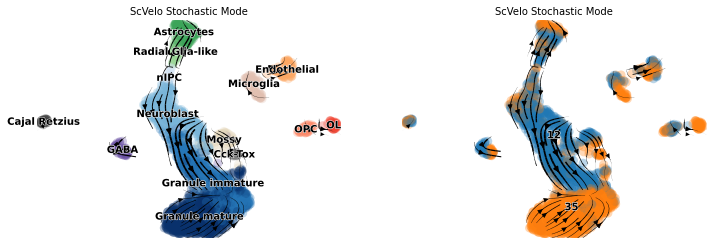

# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.5085378}
Total Mean: 0.5085378289222717
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8861011346479906}
Total Mean: -0.8861011346479906
# In-cluster Coherence
{'Astrocytes': 0.8558933, 'Cajal Retzius': 0.9876432, 'Cck-Tox': 0.9481789, 'Endothelial': 0.9474042, 'GABA': 0.90869683, 'Granule immature': 0.8450072, 'Granule mature': 0.80969536, 'Microglia': 0.9754837, 'Mossy': 0.89986753, 'Neuroblast': 0.9308812, 'OL': 0.9506476, 'OPC': 0.92203844, 'Radial Glia-like': 0.89049774, 'nIPC': 0.94443244}
Total Mean: 0.9154548048973083
# In-cluster Confidence
{'Astrocytes': 0.892010415593783, 'Cajal Retzius': 0.9845344126224518, 'Cck-Tox': 0.8860587852972525, 'Endothelial': 0.8625854274322247, 'GABA': 0.8818325673947569, 'Granule immature': 0.8406926885531966, 'Granule mature': 0.8008263841967717, 'Microglia': 0.8768389931431523, 'Mossy': 0.

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

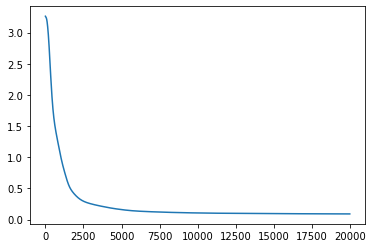

0.09180981665849686
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


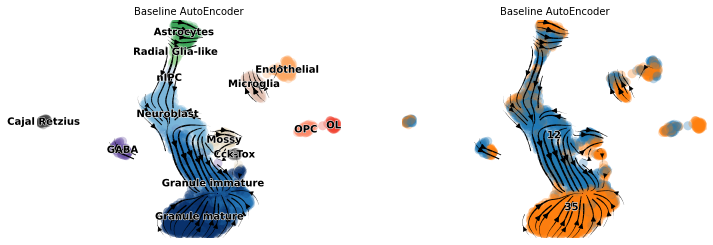

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.7684581}
Total Mean: 0.7684581279754639
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8163785985741407}
Total Mean: -0.8163785985741407
# In-cluster Coherence
{'Astrocytes': 0.98135716, 'Cajal Retzius': 0.99931806, 'Cck-Tox': 0.98328924, 'Endothelial': 0.9938483, 'GABA': 0.95072263, 'Granule immature': 0.9626219, 'Granule mature': 0.9656125, 'Microglia': 0.9983107, 'Mossy': 0.93835664, 'Neuroblast': 0.99429315, 'OL': 0.9925431, 'OPC': 0.9897141, 'Radial Glia-like': 0.99111205, 'nIPC': 0.9951889}
Total Mean: 0.9811634421348572
# In-cluster Confidence
{'Astrocytes': 0.958880116045475, 'Cajal Retzius': 0.9978231752620024, 'Cck-Tox': 0.9599094280490169, 'Endothelial': 0.9816237064613693

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model)    
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

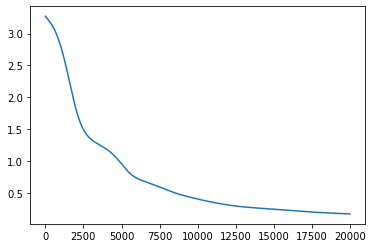

0.16736413538455963
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


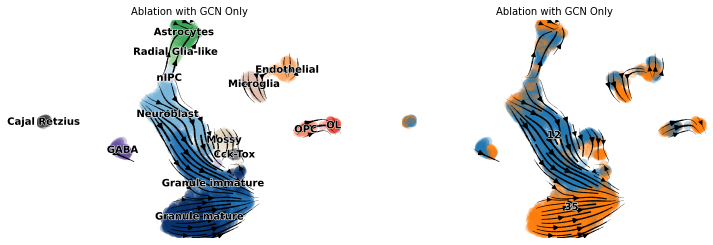

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.35521746}
Total Mean: 0.35521745681762695
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.59996617}
Total Mean: 0.5999661684036255
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.9473414696705966}
Total Mean: 0.9473414696705966
# In-cluster Coherence
{'Astrocytes': 0.9447792, 'Cajal Retzius': 0.998727, 'Cck-Tox': 0.9858646, 'Endothelial': 0.9894446, 'GABA': 0.9804117, 'Granule immature': 0.97932315, 'Granule mature': 0.97475404, 'Microglia': 0.99321145, 'Mossy': 0.9547053, 'Neuroblast': 0.9896395, 'OL': 0.96933675, 'OPC': 0.98585093, 'Radial Glia-like': 0.98554003, 'nIPC': 0.99417937}
Total Mean: 0.9804120063781738
# In-cluster Confidence
{'Astrocytes': 0.9432448014616966, 'Cajal Retzius': 0.998602477943196, 'Cck-Tox': 0.9725408465773971, 'Endothelial

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    conn = adata.obsp['connectivities']
    nb_indices = adata.uns['neighbors']['indices']
    xs, ys = np.repeat(range(n_cells), nb_indices.shape[1]-1), nb_indices[:, 1:].flatten()
    edge_weight = torch.FloatTensor(conn[xs,ys]).view(-1).to(device)
    edge_index = torch.LongTensor(np.vstack([xs.reshape(1,-1), xs.reshape(1, -1)])).to(device)
    
    model = get_ablation_CohAgg(edge_index,
                                edge_weight,
                                in_dim,
                                z_dim,
                                h_dim,
                                device)
    model = main_AE(args, model)
    
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

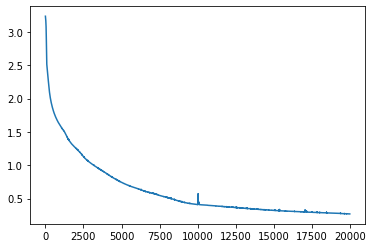

0.2709537148475647
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


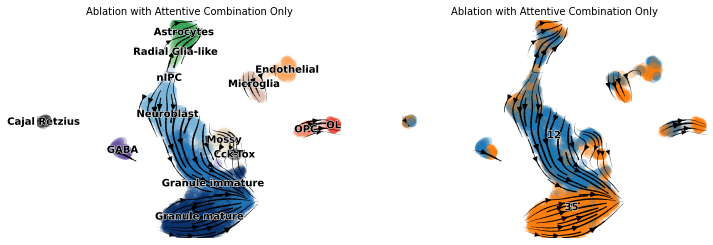

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.83889353}
Total Mean: 0.8388935327529907
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.90788007}
Total Mean: 0.9078800678253174
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.9846304071646006}
Total Mean: 0.9846304071646006
# In-cluster Coherence
{'Astrocytes': 0.9427274, 'Cajal Retzius': 0.9970866, 'Cck-Tox': 0.9976144, 'Endothelial': 0.8965702, 'GABA': 0.99184763, 'Granule immature': 0.9963603, 'Granule mature': 0.996525, 'Microglia': 0.8917374, 'Mossy': 0.9857727, 'Neuroblast': 0.9891068, 'OL': 0.99864286, 'OPC': 0.99211544, 'Radial Glia-like': 0.9472615, 'nIPC': 0.86421525}
Total Mean: 0.9633988738059998
# In-cluster Confidence
{'Astrocytes': 0.9364998862147331, 'Cajal Retzius': 0.9966712874524734, 'Cck-Tox': 0.9922661185264587, 'Endothelial': 

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        device)
    model = main_AE(args, model, lr=5e-6)
    
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


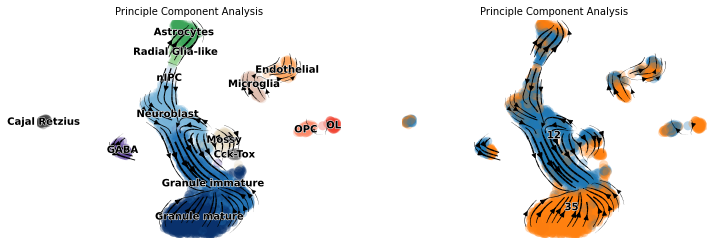

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.5289762}
Total Mean: 0.5289762020111084
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8125641294089667}
Total Mean: -0.8125641294089667
# In-cluster Coherence
{'Astrocytes': 0.9439087, 'Cajal Retzius': 0.9973554, 'Cck-Tox': 0.97945607, 'Endothelial': 0.97947156, 'GABA': 0.9464742, 'Granule immature': 0.94226104, 'Granule mature': 0.9377052, 'Microglia': 0.9963783, 'Mossy': 0.93858266, 'Neuroblast': 0.97694534, 'OL': 0.9873173, 'OPC': 0.97751343, 'Radial Glia-like': 0.96254957, 'nIPC': 0.9823303}
Total Mean: 0.9677320122718811
# In-cluster Confidence
{'Astrocytes': 0.9415012677510579, 'Cajal Retzius': 0.9963979703538558, 'Cck-Tox': 0.9514658340701351, 'Endothelial': 0.976318273051031

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


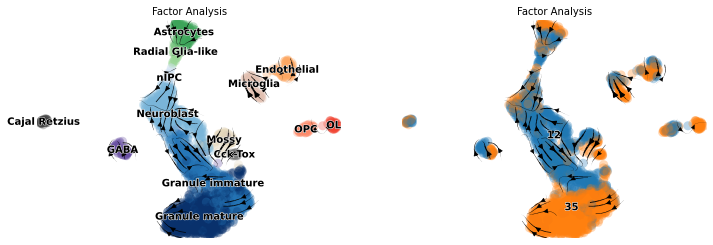

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.101896375}
Total Mean: 0.10189637541770935
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.6654870392532339}
Total Mean: 0.6654870392532339
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.06826923694459747}
Total Mean: 0.06826923694459747
# In-cluster Coherence
{'Astrocytes': 0.7984572554574432, 'Cajal Retzius': 0.9959456579146514, 'Cck-Tox': 0.9833132534649002, 'Endothelial': 0.8824452934337399, 'GABA': 0.8976361817275672, 'Granule immature': 0.7952088564570364, 'Granule mature': 0.7524815896996621, 'Microglia': 0.9110798317179198, 'Mossy': 0.9085000451265802, 'Neuroblast': 0.8952144361375, 'OL': 0.9513510018571565, 'OPC': 0.9393988662302993, 'Radial Glia-like': 0.9067583336571079, 'nIPC': 0.9405269969033088}
Total Mean: 0.8970226856989194
# In-clust

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [17]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)